In [96]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [97]:
import tensorflow as tf

In [84]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import scipy.io as scio
from IPython import display

In [98]:
dataFile1 = 'C:/Users/dell/Desktop/data/data_sub1_abdPelvis_dxCoord.mat'
data1 = scio.loadmat(dataFile1)['CT'].transpose(2,0,1)

dataFile2 = 'C:/Users/dell/Desktop/data/data_sub2_abdPelvis_dxCoord.mat'
data2 = scio.loadmat(dataFile2)['CT'].transpose(2,0,1)

dataFile4 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
data4 = scio.loadmat(dataFile4)['CT'].transpose(2,0,1)

dataFile6 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
data6 = scio.loadmat(dataFile6)['CT'].transpose(2,0,1)

dataFile7 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
data7 = scio.loadmat(dataFile7)['CT'].transpose(2,0,1)

dataFile8 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
data8 = scio.loadmat(dataFile8)['CT'].transpose(2,0,1)

dataFile13 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
data13 = scio.loadmat(dataFile13)['CT'].transpose(2,0,1)

dataFile14 = 'C:/Users/dell/Desktop/data/data_sub14_abdPelvis_dxCoord.mat'
data14 = scio.loadmat(dataFile14)['CT'].transpose(2,0,1)

data = np.concatenate((data1,data2,data4,data6,data7,data8,data13,data14),axis=0)


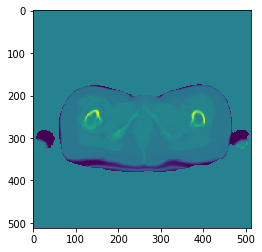

In [117]:
plt.imshow(data[1,:,:,0])

In [99]:
BUFFER_SIZE = 10
BATCH_SIZE = 10
data_min = np.min(data)
data_gap = np.max(data)-np.min(data)
data = (data - np.min(data)) / (np.max(data)-np.min(data)) # 将图片标准化到 [-1, 1] 区间内
data = data.reshape(data.shape[0], 512, 512, 1).astype('float32')

train_images = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [100]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*1, use_bias=False, input_shape=(100,)))  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 64, 1)))
    assert model.output_shape == (None, 64, 64, 1) # 注意：batch size 没有限制

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 512, 512, 1)

    return model

In [101]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding='same',
                                     input_shape=[512,512,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

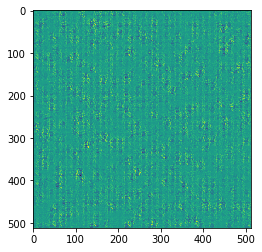

In [102]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [103]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00056943]], shape=(1, 1), dtype=float32)


In [104]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [105]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [106]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [107]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [108]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [109]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16


# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [110]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [111]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # 继续进行时为 GIF 生成图像
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 每 15 个 epoch 保存一次模型
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 最后一个 epoch 结束后生成图片
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [112]:
def generate_and_save_images(model, epoch, test_input):
  # 注意 training` 设定为 False
  # 因此，所有层都在推理模式下运行（batchnorm）。
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * data_gap + data_min)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

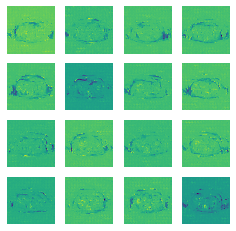

Wall time: 17h 45min 23s


In [113]:
%%time
train(train_images, EPOCHS)   

In [114]:
'用 imageio 库生成gif'
import os
import imageio
path=r'C:\Users\dell\Desktop\kerascode'
pathes=[]
for files in os.listdir(path):
    if files.endswith('jpg') or files.endswith('jpeg') or files.endswith('png'):
        file=os.path.join(path,files)
        pathes.append(file)
 
images=[]
i = 0
for path1 in pathes:
    i += 1
    print(i)
    images.append(imageio.imread(path1))
 
imageio.mimsave(r'C:\Users\dell\Desktop\kerascode\result.gif',images,duration=0.1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
